In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import os
import math
from datetime import date, timedelta
import datetime
import itertools
import random
import urllib
import io

def load_array(url):
    with urllib.request.urlopen(url) as u:
        contentLen = u.headers['content-length']
        try:
            contentLen = int(contentLen)
        except():
            contentLen = 0
        print("Downloading '{0}'".format(url.split("/")[-1]), " ({0} bytes)".format(contentLen) if contentLen > 0 else "")
        dlCount = 0
        block_sz = 8192
        result = bytes()
        while True:
            buffer = u.read(block_sz)
            result += buffer
            if not buffer:
                print()
                break
            dlCount += len(buffer)
            print("%10d  [%3.2f%%]" % (dlCount, dlCount * 100. / contentLen), end="\r")
        return np.load(io.BytesIO(result))
    
def index_at_equal_day(daynum, arr):
    for i, dp in enumerate(arr[:]):
        if dp[0] == daynum:
            return i
        elif dp[0] > daynum:
            break
    return None

FIRST_DAY = date(1900, 1, 1)
def make_date(daynum):
    return FIRST_DAY + timedelta(daynum)

def linear_interpolate_missing_values(before_val, after_val):
    dx = after_val[0] - before_val[0]
    dydx = list([((av - bv) / dx) for bv, av in zip(before_val[1:], after_val[1:])])
    count = len(before_val)
    for next_day in range(int(before_val[0]) + 1, int(after_val[0])):
        #gen = [(before_val[i] + (next_day - before_val[0]) * dydx[i - 1]) for i in range(1, count)]
        gen = [0.0 for i in range(1, count)]
        yield [next_day] + list(gen)

def normalize(x, min, max):
    return (x - min) / (max - min)

def min_max(min_max_arr, min_max_new):
    for i in range(0, len(min_max_arr)):
        min_max_arr[i][0] = min(min_max_arr[i][0], min_max_new[i])
        min_max_arr[i][1] = max(min_max_arr[i][1], min_max_new[i])
        

def create_input_data(timespan):
    #flares_data = np.load(os.path.join(workDir, '../data/astronomical/solar_flares.npy'))
    flares_data = load_array('http://localhost:8080/astronomical_data/solar_flares.npy')
    #irradiance_data = np.load(os.path.join(workDir, '../data/astronomical/solar_irradiance.npy'))
    irradiance_data = load_array('http://localhost:8080/astronomical_data/solar_irradiance.npy')
    #total_sunspots = np.load(os.path.join(workDir, '../data/astronomical/total_sunspots.npy'))
    total_sunspots = load_array('http://localhost:8080/astronomical_data/total_sunspots.npy')

    flares_data2 = []
    last_day = flares_data[0][0]
    num_flares = 0
    total_xray = 0
    print("Setting up flare data...")
    for day, start_time, delta_time, _, _, x_ray in flares_data:
        if last_day != day:
            flares_data2.append([day, num_flares, total_xray])
            last_day = day
            num_flares = 0
            total_xray = 0
        total_xray += x_ray
        num_flares += 1
    if num_flares > 0:
        flares_data2.append([day, num_flares, total_xray])
    del flares_data

    print("Making data set...")
    irr_arr = None
    flare_arr = None
    sun_arr = None
    start_day = None
    for i, sunspots in enumerate(total_sunspots[:]):
        if i % 10 == 0:
            print("Skipping data: {}, {}".format(i, make_date(int(sunspots[0]))), end='            \r')
        flare_index = index_at_equal_day(int(sunspots[0]), flares_data2[:])
        if flare_index is None:
            continue
        irr_index = index_at_equal_day(int(sunspots[0]), irradiance_data[:])
        if irr_index is None:
            continue
        irr_arr = list(irradiance_data[irr_index:])
        flare_arr = list(flares_data2[flare_index:])
        sun_arr = list(total_sunspots[i:])

        start_day = int(sunspots[0])
        break
    if irr_arr is None or flare_arr is None:
        raise('Could not zip data.')

    last_day = min(int(sun_arr[-1][0]), int(irr_arr[-1][0]), int(flare_arr[-1][0]))

    def make():
        min_max_irradiance = list([[np.inf, 0.0] for _ in range(7)])
        min_max_sunspot = list([[np.inf, 0.0] for _ in range(2)])

        for i, d in enumerate(range(start_day, last_day + 1)):
            sunspot = sun_arr[i]
            irradiance = irr_arr[i]
            flare = flare_arr[i]

            # linear interpolate data points if missing
            if int(sunspot[0]) > d:
                before_val = sun_arr[i - 1]
                val = list(linear_interpolate_missing_values(before_val, sunspot))
#                print("(Sunspots) Interpolating at {}->{}\n\tFrom: {}\n\t[{}, ... {}]\n\tTo: {}"
#                    .format(make_date(int(before_val[0])), make_date(int(sunspot[0])), before_val, val[0], val[-1], sunspot))
                sun_arr[i:i] = val
                sunspot = sun_arr[i]

            # linear interpolate data points if missing
            if int(irradiance[0]) > d:
                before_val = irr_arr[i - 1]
                val = list(linear_interpolate_missing_values(before_val, irradiance))
#                print("(Irradiance) Interpolating at {}->{}\n\tFrom: {}\n\t[{}, ... {}]\n\tTo: {}"
#                    .format(make_date(int(before_val[0])), make_date(int(irradiance[0])), before_val, val[0], val[-1], irradiance))
                irr_arr[i:i] = val
                irradiance = irr_arr[i]

            # linear interpolate data points if missing
            if int(flare[0]) > d:
                before_val = flare_arr[i - 1]
                val = list(linear_interpolate_missing_values(before_val, flare))
#                print("(SolFlares) Interpolating at {}->{}\n\tFrom: {}\n\t[{}, ... {}]\n\tTo: {}"
#                    .format(make_date(int(before_val[0])), make_date(int(flare[0])), before_val, val[0], val[-1], flare))
                flare_arr[i:i] = val
                flare = flare_arr[i]

            realDate = make_date(int(sunspot[0]))
            if i % 20 == 0:
                print("Generating data: {}".format(realDate), end='            \r')

            min_max(min_max_irradiance, irradiance)
            min_max(min_max_sunspot, sunspot)
            
            number_of_day_in_year = (realDate - date(realDate.year, 1, 1)).days

            yield [d,
               [
                  # number_of_day_in_year,
                    normalize(flare[1], 0, 50), 
                    flare[2] / 250000, 
                    normalize(irradiance[1], 28446, 28760),
                    #normalize(irradiance[2], 2, 108),
                    normalize(irradiance[3], 348556, 350568),
                    #normalize(irradiance[4], 6, 575),
                    normalize(irradiance[5], 173064, 173503),
                    #normalize(irradiance[6], 1517, 33734),
                    normalize(sunspot[1], 0, 428)
               ]]

    # contains per day the following array:
    #   0. index: number of solar flares that day
    #   1. index: total xray emission from all solar flares that day
    #   2. index: total ultraviolet (115.5nm-380nm) energy (in W/m^2) at a distance of 1au
    #   3. index: total light energy (380nm-772.5nm) energy (in W/m^2) at a distance of 1au
    #   4. index: total infrared (777.5nm-99975nm) energy (in W/m^2) at a distance of 1au
    #   5. index: number of sunspots that day
    # where the number of days since 1.1.1900 for each data_array is given by: start_day + index
    data = list(make())
    
    num_days_in_dataset = len(data)
    last_index = num_days_in_dataset - timespan if num_days_in_dataset >= timespan else 0
    print("last_index: {}               ".format(last_index))
    
    week_groups = list([data[x:x+timespan] for x in range(0, last_index)])
    num_groups = len(week_groups)

    return int(start_day), num_groups, week_groups

def create_output_data(start_day, num_groups, timespan):
#    weather_data = np.load(os.path.join(workDir, '../data/weather/switzerland/weather_BaselBinningen.npy'))
    weather_data = load_array('http://localhost:8080/weather_data/switzerland/weather_ZurichFluntern.npy')
    
    arr = None
    for i, val in enumerate(weather_data[:]):
        if int(val[0]) == start_day:
            arr = list(weather_data[i:])
            break
    if arr is None:
        raise('Could not find day {}'.format(start_day))
    if any([ any([w == np.nan for w in v[:]]) for v in arr[:]]):
        raise("Encountered NaN in weather data")

    def make_next(data):
        begin = start_day + timespan
        end = min(int(data[-1][0]) + 1, begin + num_groups)
        for i, d in enumerate(range(begin, end)):
            val = data[i]
            if int(val[0]) > d:
                before_val = data[i - 1]
                values = list(linear_interpolate_missing_values(before_val, val))
#                print("(Weather) Interpolating at {}->{}\n\tFrom: {}\n\t[{}, ... {}]\n\tTo: {}"
#                    .format(make_date(int(before_val[0])), make_date(int(val[0])), before_val, val[0], val[-1], val))
                data[i:i] = values
                val = data[i]
        
            # yields an array which contains:
            # 0. index: number of days since 1.1.1900
            # 1. index: array which contains the mean temperature in °C
            yield (d, [
                    #normalize(val[6], -5, 30)
                    val[6]
                ])
            
    def make_previous(data):
        end_day = min((len(data) - timespan if len(data) >= timespan else 0) + start_day, num_groups + start_day)
        
        for i, d in enumerate(range(start_day, end_day)):
            val = data[i]
            if int(val[0]) > d:
                before_val = data[i - 1]
                values = list(linear_interpolate_missing_values(before_val, val))
#                print("(Weather) Interpolating at {}->{}\n\tFrom: {}\n\t[{}, ... {}]\n\tTo: {}"
#                    .format(make_date(int(before_val[0])), make_date(int(val[0])), before_val, val[0], val[-1], val))
                data[i:i] = values
                val = data[i]
        
            # yields an array which is a group of timespan days of the mean temperature in °C
            yield [d, list([
               #normalize(v[6], -5, 30) for v in arr[i:i+timespan]
               v[6] for v in arr[i:i+timespan]
            ])]
    return list(make_next(list(arr[timespan:]))), list(make_previous(arr))

TIME_SPAN = 60

start_day, num_groups, x_arr = create_input_data(TIME_SPAN)
y_arr, x_temps = create_output_data(start_day, num_groups, TIME_SPAN)

print("astro_data_len: {}".format(num_groups))
print("next_weather_data_len: {}".format(len(y_arr)))
print("previous_weather_data_len: {}".format(len(x_temps)))

x = np.array(
    list([ 
        list([ 
            w[0][1] for w in zip(v[0], v[1][1])
        ])
        for v in zip(x_arr, x_temps)
    ]))

# check lengths of arrays
last_len = len(x[0])
for i, e in enumerate(x):
    if len(e) != last_len:
        print("len {}, last_len{}, index: {}".format(len(e), last_len, i))
        last_len = len(e)

x = np.nan_to_num(x, copy=False)
y = np.array(list([v[1][0] for v in y_arr]))
y = np.nan_to_num(y, copy=False)

# x = np.array(x[:20])
# y = np.array(y[:20])

   3815936  [100.00%]
   2434112  [100.00%]
    699440  [100.00%]
Setting up flare data...
Making data set...
last_index: 15216                                      
   3824960  [100.00%]
astro_data_len: 15216
next_weather_data_len: 15216
previous_weather_data_len: 15216


In [64]:
def print_day_x_y(index):
    print("x_day: {} to {}".format(x_arr[index][0][0], x_arr[index][TIME_SPAN - 1][0]))
    print("x_first: {}\nx_last: {}".format(x_arr[index][0][1], x_arr[index][TIME_SPAN - 1][1]))
    print("x_temps_day: {} to {}".format(x_temps[index][0], x_temps[index][0] + TIME_SPAN - 1))
    print("x_temps: {}".format(x_temps[index][1]))
    print("x_temps_next: {}".format(x_temps[index + 1][1]))
    print("y: {}".format(y_arr[index]))

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.activations import relu
from tensorflow import keras

num_dims = 6

model = Sequential([
    Flatten(input_shape=(TIME_SPAN, num_dims)),
    Dropout(0.25),
    Dense(TIME_SPAN * num_dims, activation='relu'),
    Dropout(0.25),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(512, activation='relu'),
    Dense(1, activation='linear')
], "v1")
 
model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')

cb = keras.callbacks.LambdaCallback(on_epoch_end=lambda epch, logs: print('Epoch {}: {}'.format(epch+1, logs['loss']), end='     \r'))
model.fit(x=x, y=y, epochs=150, verbose=0, validation_split=0.2, shuffle=True, callbacks=[cb])


start_date: 2003-12-08, end_date: 2017-04-29
mse: 57.256513822417354
act_min: -13.5
act_max: 27.8
act_range: 41.3
pred_min: -3.8300375938415527
pred_max: 9.390534400939941
pred_range: 13.220571994781494
mean_abs_error: 6.406829144761212
mean_rel_error: 0.2279251081710491



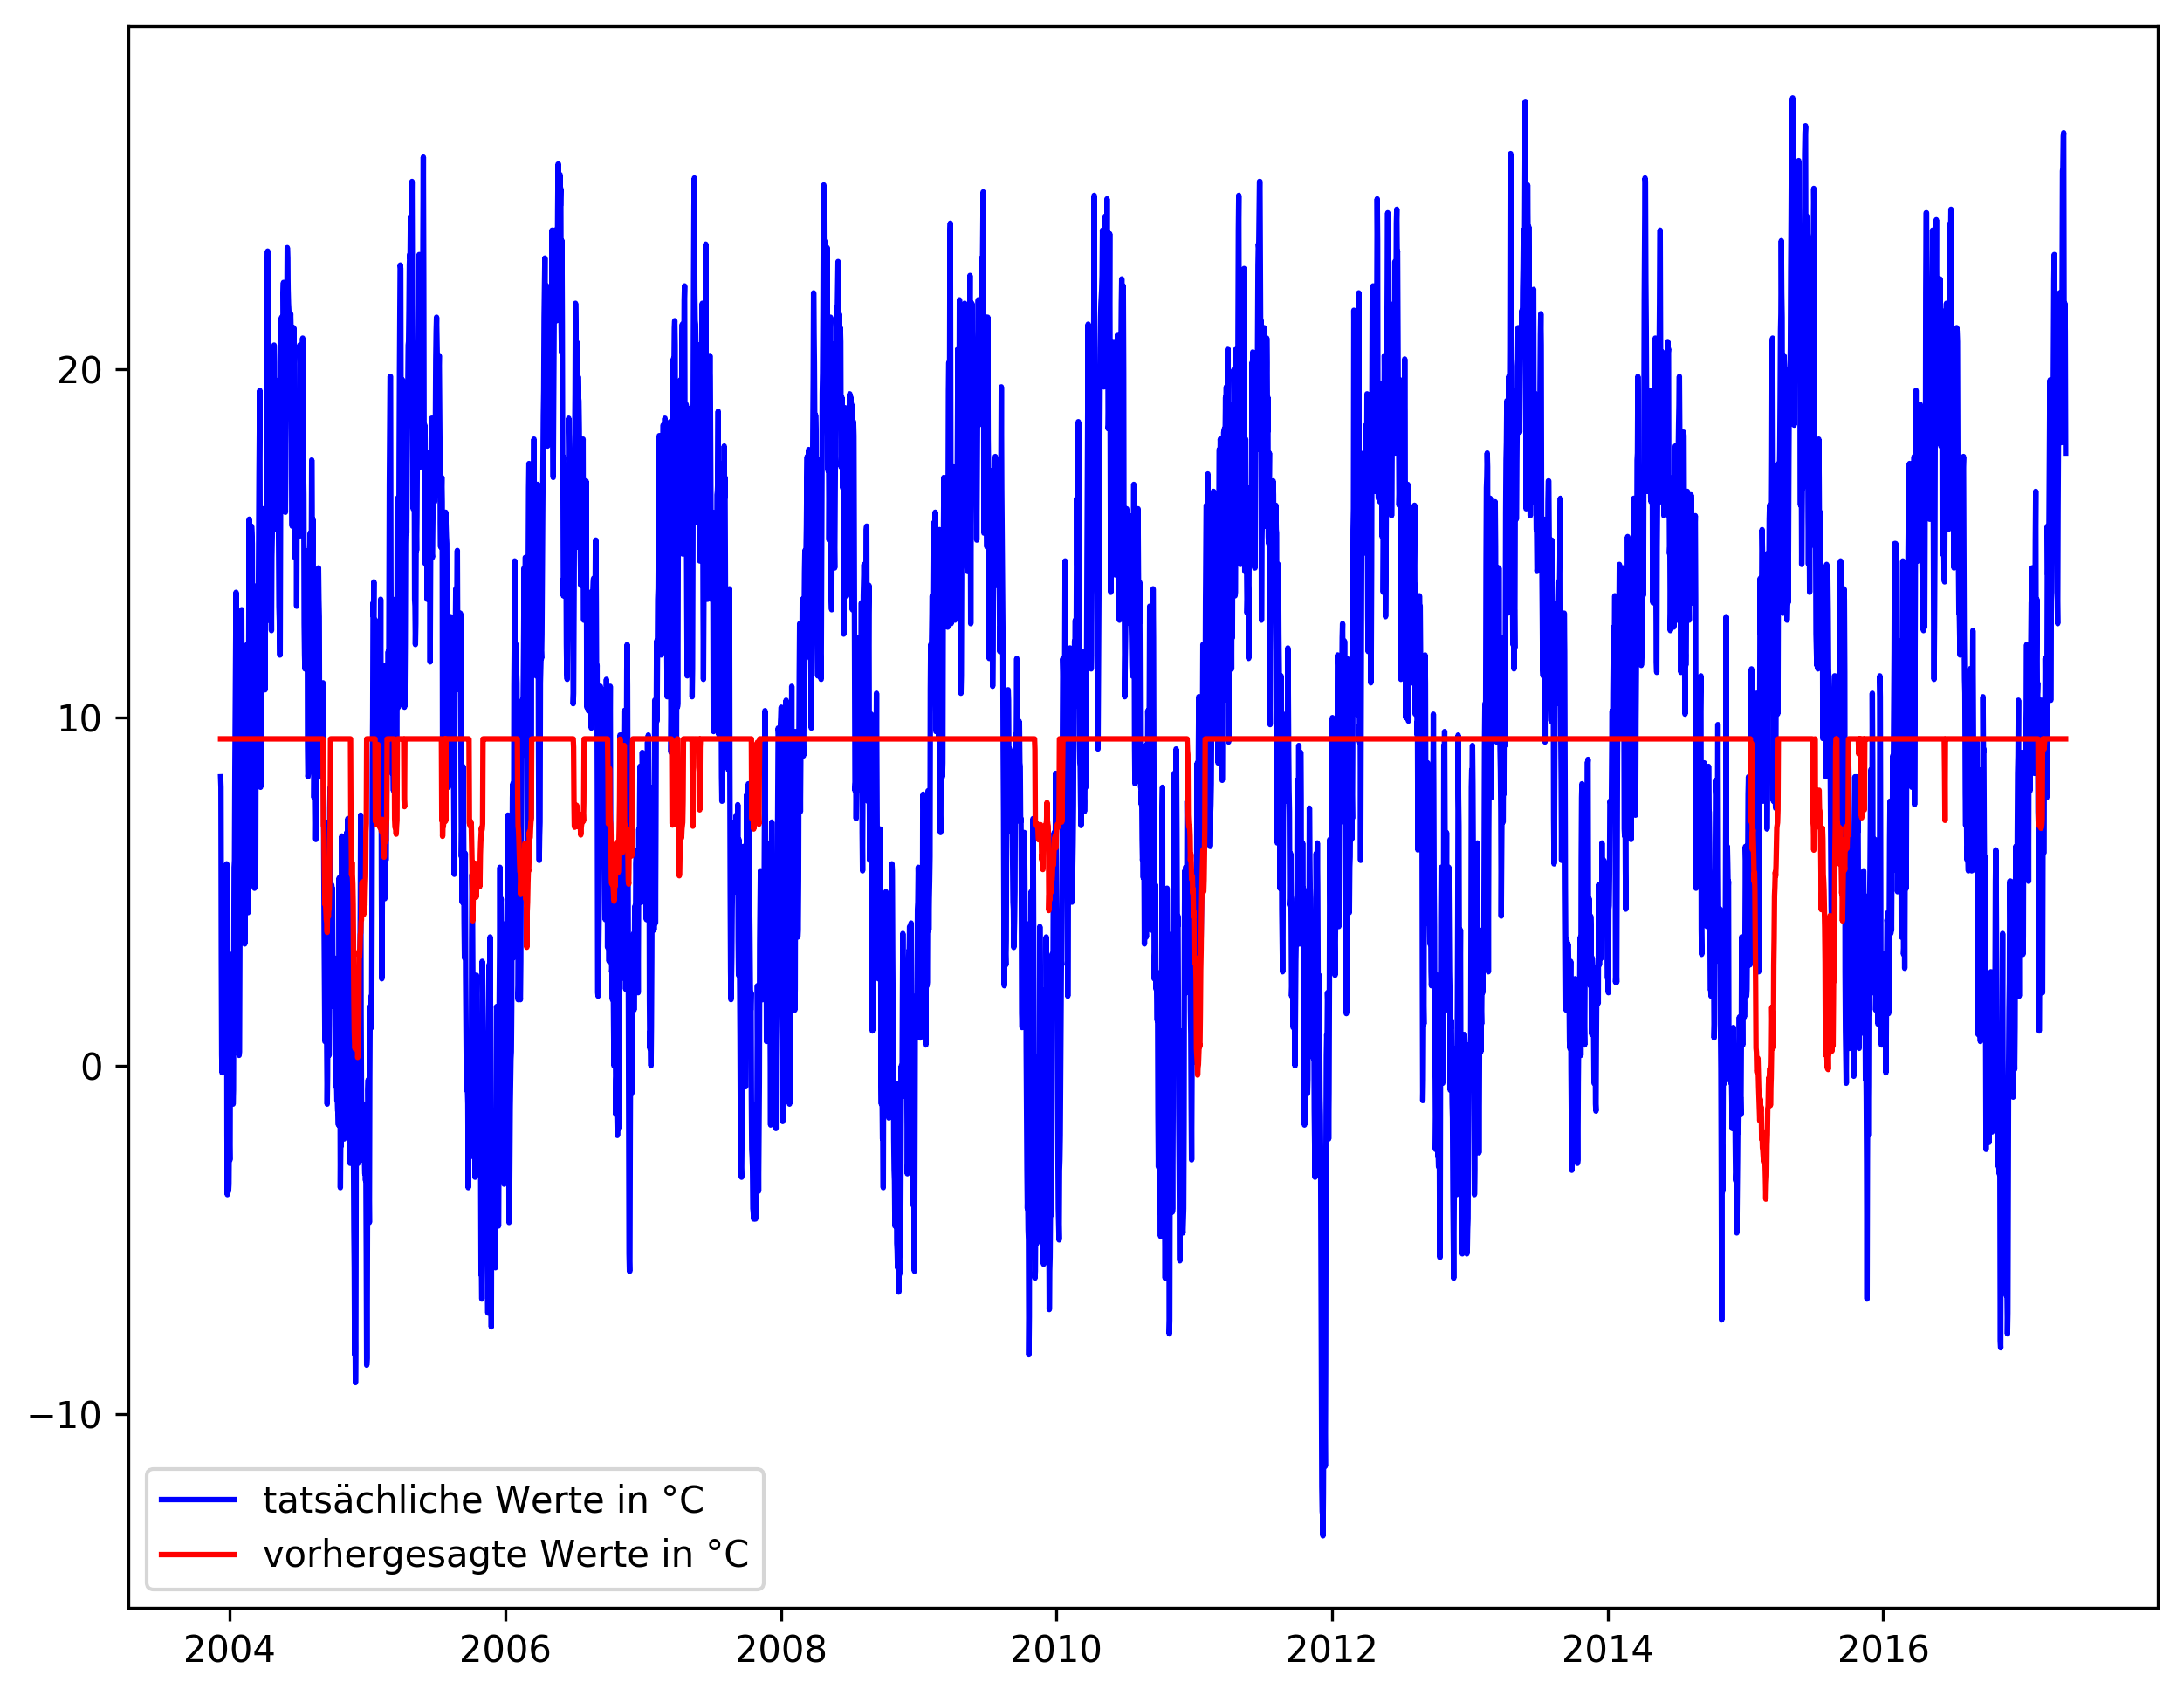

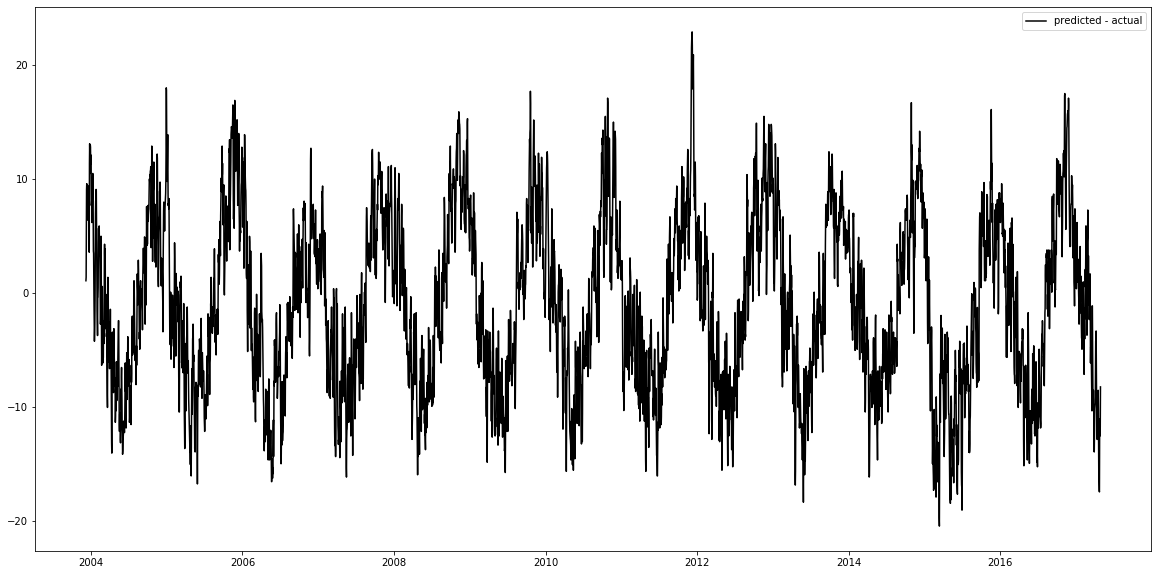

start_date: 1975-09-02, end_date: 2017-04-29
mse: 54.73192589556644
act_min: -18.1
act_max: 27.8
act_range: 45.900000000000006
pred_min: -3.8300375938415527
pred_max: 9.390534400939941
pred_range: 13.220571994781494
mean_abs_error: 6.22816482705663
mean_rel_error: 0.23367451072388695



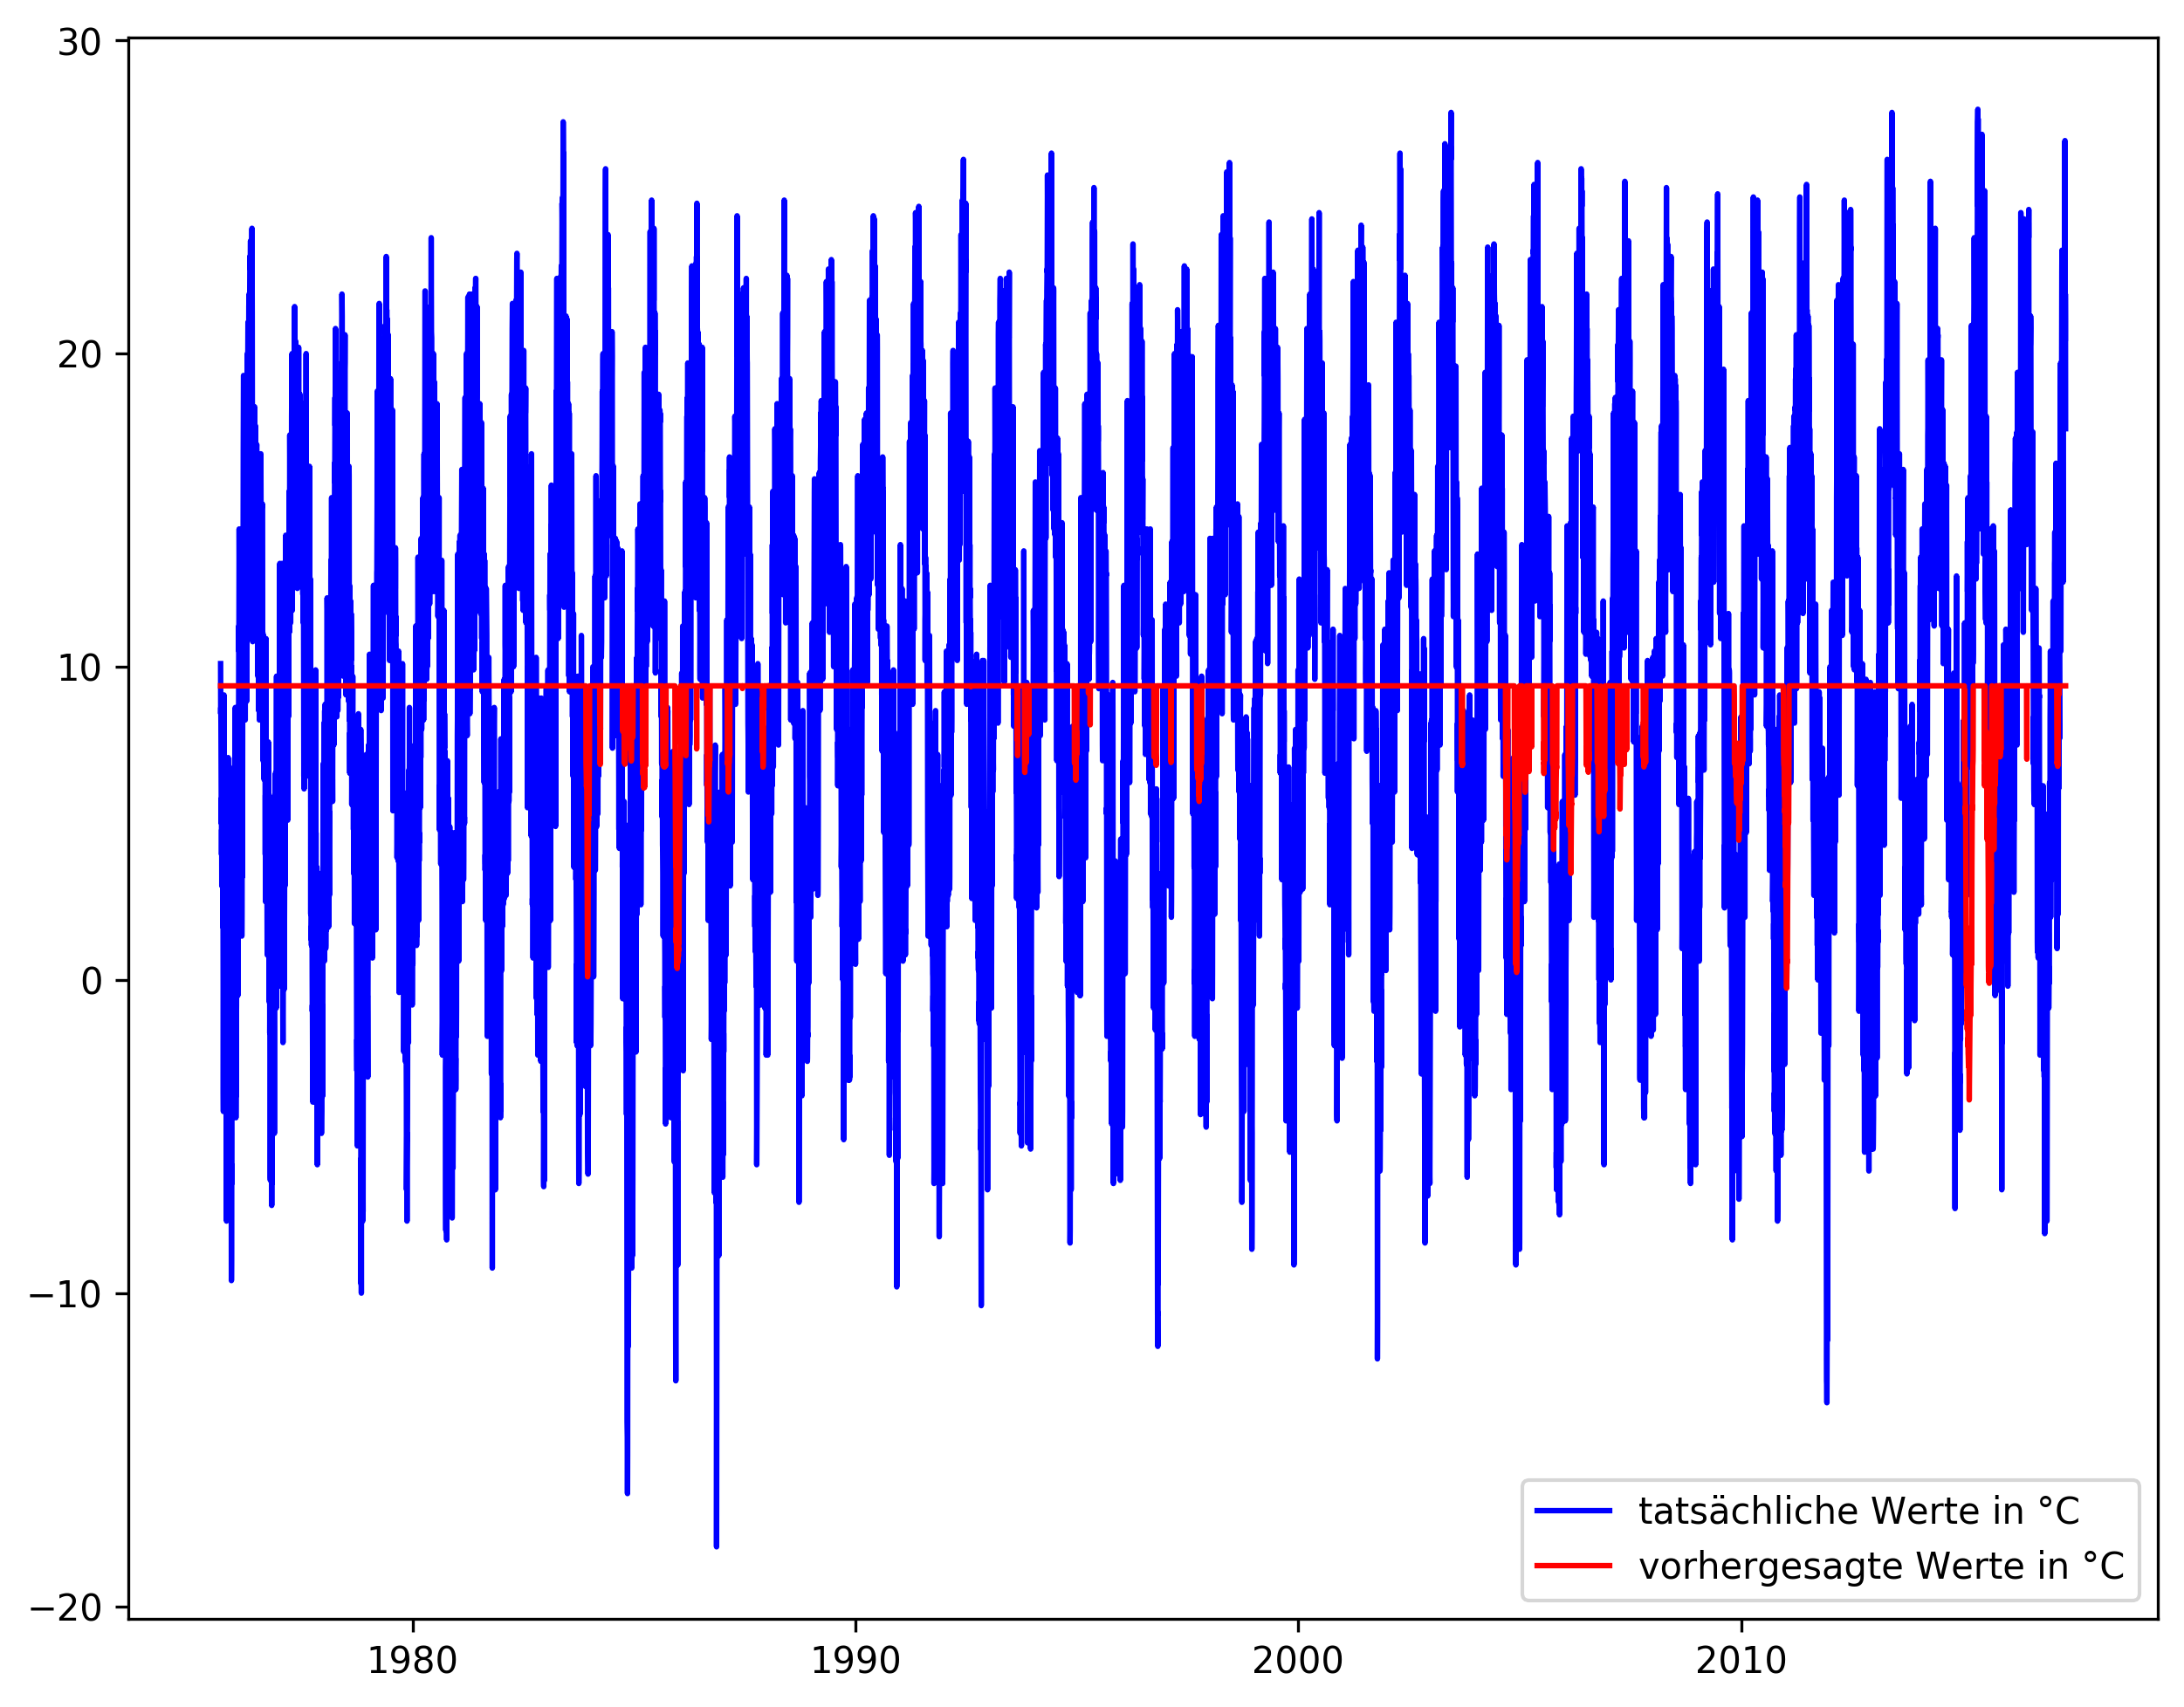

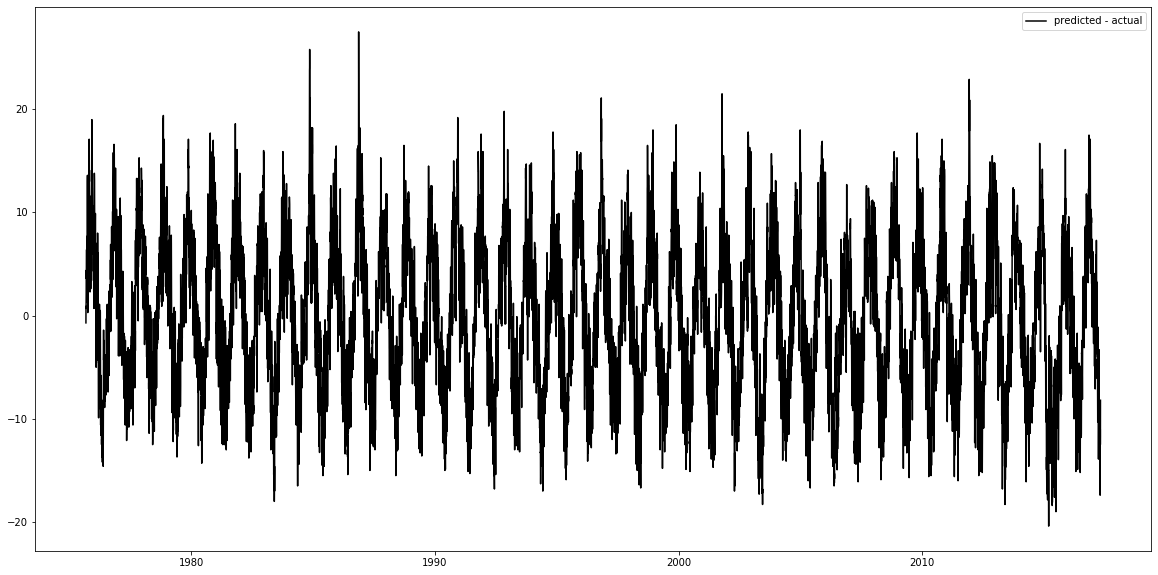

In [74]:
import calendar

predicted_x = model.predict(x=x)
    
def show_graph(start, end):
    predicted = []
    actual = []
    was_data = []
    
    mse = 0.0
    count = 0
    abs_err = 0.0
    rel_err = 0.0

    for i, (x_data, y_data, x_prediction) in enumerate(zip(x[0:], y[0:], predicted_x)):
        if i < start:
            continue
        elif i > end:
            break
        predicted.append(x_prediction.tolist()[0])
        actual.append(float(y_data))

        mse += (float(y_data) - float(x_prediction)) ** 2
        count += 1
        abs_err += abs(float(y_data) - float(x_prediction))
        rel_err += abs(float(y_data) - float(x_prediction)) / (float(y_data) if float(y_data) != 0 else 1)

        was_data.append(x_data)

    print("start_date: {}, end_date: {}".format(make_date(start + start_day), make_date(end + start_day)))
    print("mse: {}".format(mse / float(count)))
    print("act_min: {}".format(np.min(np.array(actual))))
    print("act_max: {}".format(np.max(np.array(actual))))
    print("act_range: {}".format(np.max(actual) - np.min(actual)))
    print("pred_min: {}".format(np.min(np.array(predicted))))
    print("pred_max: {}".format(np.max(np.array(predicted))))
    print("pred_range: {}".format(np.max(predicted) - np.min(predicted)))
    print("mean_abs_error: {}".format(abs_err / float(count)))
    print("mean_rel_error: {}".format(rel_err / float(count)))
    print()

    def fract_year(day_num):
        real_date = make_date(day_num)
        num_days = 366 if calendar.isleap(real_date.year) else 365
        return real_date.year + ((real_date - date(real_date.year, 1, 1)).days / num_days)

    data = {
        'yActual': actual,
        'yPredicted': predicted,
        'x': list([fract_year(x) for x in range(start + start_day, end + 1 + start_day)])
    }


    plt.figure(figsize=(10,8), dpi=300)
    plt.plot('x', 'yActual', data=data, color='blue', label='tatsächliche Werte in °C')
    plt.plot('x', 'yPredicted', data=data, color='red', label='vorhergesagte Werte in °C')
    plt.legend()
    plt.show()

    data = {
        'yDiff': list([pred - act for act, pred in zip(actual, predicted)]),
        #'yDiff': list([v[0][0] for v in was_data]),
        'x': list([fract_year(x) for x in range(start + start_day, end + 1 + start_day)])
    }


    plt.figure(figsize=(20,10))
    plt.plot('x', 'yDiff', data=data, color='black', label='predicted - actual')
    plt.legend()
    plt.show()
    
show_graph(29*356, len(predicted_x) - 1)
show_graph(0, len(predicted_x) - 1)